# Genome Mining Script
##### Original Author: Chun Yin Larry So | Python Interpretation: Nathan Alam
[Github repository](https://github.com/nathanalam/genomemining)

The purpose of this notebook is to provide scripts for reading bacterial genomes in search of regular expressions which seem to match a String corresponding to a candidate coding for a Lasso peptide.

## Links to relevant publications:
- [Genome mining for lasso peptides: past, present, and future](https://link.springer.com/article/10.1007/s10295-019-02197-z)
- [Prospecting Genomes for Lasso Peptides](https://www.ncbi.nlm.nih.gov/pubmed/24142336)

### Comments from Perl Script
- In this version each time MAST needs to be run on a putative maturation enzyme in a particular genome, a lookup in the database is performed to check if this protein has been analyzed by MAST before and if it has then use the values from before
- In this version traseq will be used instead of getorf for finding precursors
- getorf is still used for finding neighbors
- Like v4 except that multiple proteins of the same sequence don't cause wrong locations of maturation enzymes to be reported
- Another change is that the pattern needs to be adjusted to [MVL] instead of ^ in the beginning
- This version fixes the problem of having a useless %AME hash and also of erasing sequences from %AME_scores
- Precursor pattern is output into the log file
- ORF searching behavior is changed from stop-to-stop to [MVL]-to-stop
- Clusters of precursors are saved in clusters.txt
- **Warning**: transeq doesn't label the -1, -2, -3 frames sequentially. Sometimes it is -1, -3, -2, sometimes some other combination. This means the precursor locations on the reverse strand are off by one sometimes
- Take note that rank_hits expects 4 motifs for the B enzyme and 3 motifs for the C enzyme. Adjust accordingly.

In [1]:
import re
import sys
import os
import json
import math

### THE Pattern

This is the pattern that we're using to identify lasso proteins. TODO - Use Machine Learning to adjust the pattern to maximize the number of valid lasso proteins.

In [2]:
PATTERN = 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*'
# PATTERN = 'CC.CGCCC...TGGC.'
# PATTERN = '.*'

### FASTA Function

Define a function that takes as input the relative path of a FASTA formatted text file, return an object that contains a list of sequence objects. Each sequence object has a description field ["description"] and a sequence field ["sequence"].

From http://www.csbio.sjtu.edu.cn/bioinf/virus-multi/example.htm, specification of a FASTA formatted file:
- The first line of each query protein input format must begin with a greater-than (">") symbol in the first column. The word following the ">" symbol is the identifier and description of the sequence, but both are optional.
- The sequence (in single-character code) begins in a different line and ends if another line starting with a ">" appears, which indicates the start of another query protein.

In [3]:
def readFASTA(name, cleanspace = 0):
    descriptions = []
    sequences = []
    sequenceList = []
    tempSequences = []     
        
    with open(name) as file:
        count = -1
        for line in file:
            
            if(line[0] == '>'):
                # if begins with a >, then a description
                descriptions.append(line[1:].replace('\n', ''))
                count += 1
                # skip the first time
                if count > 0 :
                    # combine the tempSequences into a single string and
                    # add it to sequences
                    newSequence = ' '.join(tempSequences)
                    # now remove all of the whitespaces
                    newSequence = newSequence.replace(' ', '')
                    newSequence = newSequence.replace('\n', '')
                    
                    sequences.append(newSequence)
                    # refresh the tempSequence list
                    tempSequences = []
                    
                    sequenceList.append({
                        "description": descriptions[count - 1],
                        "sequence": sequences[count - 1]
                    })
            else:
                tempSequences.append(line)
                
        # combine the tempSequences into a single string and
        # add it to sequences
        newSequence = ' '.join(tempSequences)
        # now remove all of the whitespaces
        newSequence = newSequence.replace(' ', '')
        newSequence = newSequence.replace('\n', '')

        sequences.append(newSequence)
        # refresh the tempSequence list
        tempSequences = []
        
        sequenceList.append({
            "description": descriptions[count],
            "sequence": sequences[count]
        })
                
                
    if len(descriptions) != len(sequences):
        print("ERROR: Number of descriptions does not match number of sequences")
        print("Number of descriptions: " + str(len(descriptions)))
        print("Number of sequences: " + str(len(sequences)))
        sys.exit(1);
        
    print("Read " + str(count + 1) + " objects from FASTA file " + name)
        
    return sequenceList
        


### Obtain Amino acid sequence directories

Begin by getting a list of all of the genomes available in the genomes folder alongside this script.

In [4]:
ALLDIRNAMES = []
for dirname in os.listdir("genomes"):
    ## if a regular file, just add to directory
    if (dirname.find(".") != -1):
        ALLDIRNAMES.append("genomes/" + dirname)
    else:
        for filename in os.listdir("genomes/" + dirname):
            ALLDIRNAMES.append("genomes/" + dirname + "/" + filename)

In [5]:
print(ALLDIRNAMES)

['genomes/allgenomes.fna']


In [6]:
thing = readFASTA(ALLDIRNAMES[0])
print(len(thing))

Read 29 objects from FASTA file genomes/allgenomes.fna
29


### Clear Directory
Delete all translated directories for further testing. **ONLY DO THIS IF YOU KNOW WHAT YOU'RE DOING**

In [25]:
# for dirname in ALLDIRNAMES:
#     if (dirname[len(dirname) - 3:] == "faa"):
#         os.remove(dirname)

For the fna files, we need to convert them to amino acid sequences (or faa files). We do this using [Emboss Transeq](https://www.ebi.ac.uk/seqdb/confluence/display/JDSAT/EMBOSS+transeq+Help+and+Documentation#EMBOSStranseqHelpandDocumentation-Reference), and save the output amino acid sequences into this genome file

In [26]:
from Bio.Seq import Seq, reverse_complement, translate
from Bio.Alphabet import IUPAC

# takes a three letter codon, and returns the corresponding amino acid or 'X' if unknown
def translate_codon(codonString):
    if(not len(codonString) == 3):
        raise InputError()
        
    try:
        return translate(codonString, to_stop=False, table = 11)
    except:
        return 'X'

## An adapter function for the biopython's translate, takes in a DNA sequence and returns a list of protein sequences
def get_orfs(DNAseq):
    AAList = []
    
    codonArr = []
    seqLen = len(DNAseq) - (len(DNAseq) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[0:seqLen])
    except:
        for i in range(0, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))
        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 1,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(DNAseq) - ((len(DNAseq) - 1) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[1:seqLen])
    except:
        for i in range(1, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 2,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(DNAseq) - ((len(DNAseq) - 2) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[2:seqLen])
    except:
        for i in range(2, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 3,
        "sequence": seq
    })
    
    backwards_dna = reverse_complement(DNAseq)
    codonArr = []
    seqLen = len(backwards_dna) - (len(backwards_dna) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[0:seqLen])
    except:
        for i in range(0, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))
        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -1,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(backwards_dna) - ((len(backwards_dna) - 1) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[1:seqLen])
    except:
        for i in range(1, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -2,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(backwards_dna) - ((len(backwards_dna) - 2) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[2:seqLen])
    except:
        for i in range(2, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -3,
        "sequence": seq
    })
    
    return AAList   

In [27]:
get_orfs("ATGCATGGCAGCA")

[{'ORF': 1, 'sequence': 'MHGS'},
 {'ORF': 2, 'sequence': 'CMAA'},
 {'ORF': 3, 'sequence': 'AWQ'},
 {'ORF': -1, 'sequence': 'CCHA'},
 {'ORF': -2, 'sequence': 'AAMH'},
 {'ORF': -3, 'sequence': 'LPC'}]

In [28]:
for dirname in ALLDIRNAMES:
    if((dirname[len(dirname) - 3:] == "fna") and not (dirname[:len(dirname) - 3] + "faa") in ALLDIRNAMES):
        print("Opening up " + dirname + " and converting into peptide sequences...")
        DNAseqs = []
        seqDescriptions = []
        for fastaobj in readFASTA(dirname):
            DNAseqs.append(fastaobj["sequence"])
            seqDescriptions.append(fastaobj["description"])
            
        entries = []
        for i in range(0, len(DNAseqs)):
            print("converting " + str(len(DNAseqs[i])) + " base pairs from " + seqDescriptions[i])
            aalist = get_orfs(DNAseqs[i])
            print("created " + str(len(aalist)) + " peptide sequences from " + seqDescriptions[i])
            for e in range(0, len(aalist)):
                entries.append({
                    "sequence": aalist[e]["sequence"],
                    "description": str(seqDescriptions[i] + " - ORF " + str(aalist[e]["ORF"])) 
                })
        
        print("writing read peptides into '" + dirname[len('genomes/'):len(dirname) - 3] + "faa'")
        with open(dirname[:len(dirname) - 3] + "faa", 'w') as outfile:
            for ent in entries:
                outfile.write("> " + ent["description"] + "\n")
                outfile.write(ent["sequence"] + "\n\n")

Now, we append all of the files ending in a ".faa" translation to an array of files called DIRNAMES

In [29]:
DIRNAMES = []
for dirname in os.listdir("genomes"):
    if (dirname.find(".") != -1):
        if(dirname[len(dirname) - 3:] == "faa"):
            DIRNAMES.append("genomes/" + dirname)
    else:
        for filename in os.listdir("genomes/" + dirname):
            if(filename[len(filename) - 3:] == "faa"):
                DIRNAMES.append("genomes/" + dirname + "/" + filename)
    
        
print(DIRNAMES)

['genomes/sequence.faa']


### MAST method

Define a method that lets us take a sequence and identify B and C proteins from it. Requires the sequence and the directory of the pre-generated MEME motif files as input, and returns a tuple containing the B matches and the C matches.

In [11]:
def mastSearch(sequence, memeDirB, memeDirC):
    Bproteins = []
    Cproteins = []
    with open("tempseq.txt", "w") as file:
        file.write("> " + "temporary" + "\n")
        file.write(sequence)
        file.close()

    os.system('mast -hit_list ' + memeDirB + ' tempseq.txt > tempoutB.txt')
    os.system('mast -hit_list ' + memeDirC + ' tempseq.txt > tempoutC.txt')

    with open("tempoutB.txt", "r") as file:
        inlines = file.readlines()
        inlines = inlines[2:len(inlines) - 1]

        
        for line in inlines:
            # remove ending newline character
            line = line[:len(line) - 1]
            params = line.split(' ')
            while('' in params) : 
                params.remove('') 
            try:
                newB = {
                    "strand" : int(params[1]),
                    "motif" : params[2],
                    "start" : int(params[4]),
                    "end" : int(params[5]),
                    "score" : float(params[6]),
                    "p-value" : float(params[7])
                }
                Bproteins.append(newB)
            except:
                print("error in parsing line - " + line)
                print("params: " + str(params))
        file.close()
    with open("tempoutC.txt", "r") as file:
        inlines = file.readlines()
        inlines = inlines[2:len(inlines) - 1]

        
        for line in inlines:
            # remove ending newline character
            line = line[:len(line) - 1]
            params = line.split()
            while('' in params) : 
                params.remove('') 
            try:
                newC = {
                    "strand" : int(params[1]),
                    "motif" : params[2],
                    "start" : int(params[4]),
                    "end" : int(params[5]),
                    "score" : float(params[6]),
                    "p-value" : float(params[7])
                }
                Cproteins.append(newC)
            except:
                print("error in parsing line - " + line)
                print("params: " + str(params))
        file.close()

    os.remove("tempseq.txt")
    os.remove("tempoutB.txt")
    os.remove("tempoutC.txt")

    return (Bproteins, Cproteins)

### Pattern Matching
Takes in 6 sequences corresponding to 6 ORFs of a given sequence, and then identifies B/C gene clusters within them. Then, use the python regular expression library to identify precursor peptides matching the regular expression pattern at the top of the script. The function returns a list of matched proteins, which have a specific sequence, ORF, nearest B/C cluster, and range within the overall sequence.

In [32]:
### Some helper functions
def isOverlapping(start1, end1, start2, end2):
    if (start1 <= start2) and (end1 >= start2):
        return True
    if(start2 <= start1) and (end2 >= start1):
        return True
    
    
    return False

def adjustRangeByORF(ORF, length, start, end):
    if ORF == 2:
        start += 1
        end += 1
    elif ORF == 3:
        start += 1
        end += 1
    elif ORF == -1:
        temp = start
        start = length - end
        end = length - temp
    elif ORF == -2:
        temp = start
        start = length - end - 1
        end = length - temp - 1
    elif ORF == -3:
        temp = start
        start = length - end - 2
        end = length - temp - 2
    
    return [start, end]
    

In [35]:
def patternMatch(sequenceORFs, pattern, filename):
    Aproteins = []
    Bproteins = []
    Cproteins = []
    
    
    ## generate all of the Bs and Cs, and label them by ORF
    ORFs = [1, 2, 3, -1, -2, -3]
    ORF = 0
    for pair in sequenceORFs:
        overallSequence = pair["sequence"]
        pair = mastSearch(overallSequence, "motifs/memeb.txt", "motifs/memec.txt")
        
        newBs = pair[0]
        newCs = pair[1]
        
        for b in newBs:
            b["ORF"] = ORFs[ORF]
            prange = adjustRangeByORF(ORFs[ORF], len(overallSequence), b["start"], b["end"])
            b["start"] = prange[0]
            b["end"] = prange[1]
            
            
        for c in newCs:
            c["ORF"] = ORFs[ORF]
            prange = adjustRangeByORF(ORFs[ORF], len(overallSequence), c["start"], c["end"])
            c["start"] = prange[0]
            c["end"] = prange[1]
        
        Bproteins.extend(newBs)
        Cproteins.extend(newCs)
        
        ORF += 1
        
    ## create all of the cluster points, and give them a score
    ORF = 0
    for pair in sequenceORFs:
        overallSequence = pair["sequence"]
        description = filename[8:len(filename) - 4] + " - " + pair["description"]
        # find all matches in protein that match
        matchIter = re.finditer(pattern, overallSequence)
        done_looping = False
        while not done_looping:
            try:
                match = next(matchIter)
            except StopIteration:
                done_looping = True
            else:

                # get the correct range based on span
                indices = list(match.span())
                indices = adjustRangeByORF(ORFs[ORF], len(overallSequence), indices[0], indices[1])

                # make the ranking calculation and find closest B and C
                rank = 0
                start = indices[0]
                end = indices[1]

                term1 = 0
                closest = float("inf")
                closestB = None
                if len(Cproteins) != 0:
                    for prot in Bproteins:
                        if isOverlapping(start, end, prot["start"], prot["end"]):
                            # print(str(start) + "-" + str(end) + " |B at " + str(prot["start"]) + "-" + str(prot["end"]))
                            # print(prot)
                            continue
                        diffsquared = (prot["start"] - start) ** 2
                        if diffsquared < closest:
                            closestB = prot
                            closest = diffsquared
                        term1 += (1.0 / float(diffsquared))
                            

                term2 = 0
                closest = float("inf")
                closestC = None
                if len(Bproteins) != 0:

                    for prot in Cproteins:
                        if isOverlapping(start, end, prot["start"], prot["end"]):
                            # print(str(start) + "-" + str(end) + " |C at " + str(prot["start"]) + "-" + str(prot["end"]))
                            # print(prot)
                            continue
                        diffsquared = (prot["start"] - start) ** 2

                        if diffsquared < closest:
                            closestC = prot
                            closest = diffsquared
                        term2 += (1.0 / float(diffsquared))

                rank = term1 * term2
                if rank == 0:
                    continue
                else:
                    rank = -1 * math.log(rank, 10)

                # append the protein to the list of proteins
                Aproteins.append({
                    "description": description,
                    "sequence": match.group(0),
                    "searchPattern": match.re.pattern,
                    "searchRange": indices,
                    "overallLength": len(overallSequence),
                    "rank": rank,
                    "closestB": closestB,
                    "closestC": closestC,
                    "ORF": ORFs[ORF],
                    "genome": description[:description.index("/")]
                    ## "overallString": match.string
                })
                
        ORF += 1
    return Aproteins

Some unit testing...

In [36]:
pair = readFASTA(DIRNAMES[2])
A = patternMatch(pair, PATTERN, "file/thinggenome/file")
    
print("The A proteins...")
for prot in A:
    print(str(prot["searchRange"]) + " - " + str(prot["rank"]) + " - " + str(prot["closestB"]) + " - " + str(prot["closestC"]) + " - ")

Read 6 objects from FASTA file genomes/Streptomyces_leeuwenhoekii_GCA_001013905_1/NZ_LN831788.1.faa
The A proteins...
[3417, 3486] - 8.350842598439872 - {'strand': 2, 'motif': 'LRARGVYAHLVIGVR', 'start': 3592, 'end': 3606, 'score': 665.84, 'p-value': 5.65e-05, 'ORF': -3} - {'strand': 3, 'motif': 'ARDSSAILVELSGGLDSSIVA', 'start': 3291, 'end': 3311, 'score': 126.08, 'p-value': 3.76e-05, 'ORF': -3} - 
[3927, 3987] - 9.25293317339028 - {'strand': 2, 'motif': 'LRARGVYAHLVIGVR', 'start': 3809, 'end': 3823, 'score': 544.4, 'p-value': 9.49e-05, 'ORF': 2} - {'strand': 3, 'motif': 'ARDSSAILVELSGGLDSSIVA', 'start': 3291, 'end': 3311, 'score': 126.08, 'p-value': 3.76e-05, 'ORF': -3} - 
[4833, 4893] - 10.804559997750356 - {'strand': 2, 'motif': 'LRARGVYAHLVIGVR', 'start': 4364, 'end': 4378, 'score': 584.88, 'p-value': 7.99e-05, 'ORF': 2} - {'strand': 3, 'motif': 'ARDSSAILVELSGGLDSSIVA', 'start': 3291, 'end': 3311, 'score': 126.08, 'p-value': 3.76e-05, 'ORF': -3} - 
[9620, 9686] - 10.90992026987235

### The Search
Run the pattern matching method on all of the directoried genomes

In [37]:
matchedProteins = []
for filename in DIRNAMES:
    readSequences = readFASTA(filename)
    if(not len(readSequences) == 6):
        print("Error: sequence in file " + filename + " does not have 6 sequences for 6 ORFs")
        print("Instead, it has " + str(len(readSequences)))
        raise RuntimeError
    matchedProteins.extend(patternMatch(readSequences, PATTERN, filename))
    

print("Found " + str(len(matchedProteins)) + " that satisfy the pattern: " + PATTERN)
# for match in matchedProteins:
#     print(match["sequence"] + ", found in range " + str(match["searchRange"]))
#     print("description: " + match["description"])



Read 6 objects from FASTA file genomes/Streptomyces_leeuwenhoekii_GCA_001013905_1/NZ_LN831789.1.faa
Read 6 objects from FASTA file genomes/Streptomyces_leeuwenhoekii_GCA_001013905_1/NZ_LN831790.1.faa
Read 6 objects from FASTA file genomes/Streptomyces_leeuwenhoekii_GCA_001013905_1/NZ_LN831788.1.faa
Read 6 objects from FASTA file genomes/Streptomyces_lividans_TK24_GCA_000739105_1/NZ_CP009124.1.faa
Read 6 objects from FASTA file genomes/Streptomyces_albus_GCA_000827005_1/NZ_CP010519.1.faa
Read 6 objects from FASTA file genomes/Xanthomonas_citri_citri_Aw12879_GCA_000349225_1/NC_020816.1.faa
Read 6 objects from FASTA file genomes/Xanthomonas_citri_citri_Aw12879_GCA_000349225_1/NC_020815.1.faa
Read 6 objects from FASTA file genomes/Xanthomonas_citri_citri_Aw12879_GCA_000349225_1/NC_020817.1.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_excentricus_CB_48_GCA_000175215_2/NC_014818.1.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_excentricus_CB_48_GCA_000175215_2

Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000064.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000015.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000070.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000097.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000075.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000091.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000095.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000088.faa
Read 6 objects from FASTA file genomes/Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000066.faa
Read 6 objects from FASTA file genomes/Asticca

In [38]:
matchedProteins[100]

{'description': 'Streptomyces_leeuwenhoekii_GCA_001013905_1\uf028/NZ_LN831790.1 -  gi|824057350|ref|NZ_LN831790.1| Streptomyces leeuwenhoekii genome assembly sleC34, chromosome : chromosome - ORF 1',
 'sequence': 'MSPCTKSRRGWPSSRLSGFPAYVSLSSTVIRGAPGASEASSART*',
 'searchPattern': 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\\*',
 'searchRange': [190961, 191006],
 'overallLength': 2634631,
 'rank': 11.562712028666043,
 'closestB': {'strand': 4,
  'motif': 'CLPRSIAL',
  'start': 189626,
  'end': 189633,
  'score': 1029.4,
  'p-value': 3.57e-05,
  'ORF': 2},
 'closestC': {'strand': 3,
  'motif': 'ARDSSAILVELSGGLDSSIVA',
  'start': 191811,
  'end': 191831,
  'score': 427.84,
  'p-value': 1.24e-05,
  'ORF': -3},
 'ORF': 1,
 'genome': 'Streptomyces_leeuwenhoekii_GCA_001013905_1\uf028'}

In [39]:
with open('matches.json', 'w') as outfile:
    json.dump(matchedProteins, outfile)

In [30]:
lassopeptides = []
with open('matches.json', 'r') as storedfile:
    lassopeptides = json.loads(storedfile.read())


In [31]:
things = readFASTA(ALLDIRNAMES[1])

Read 1 objects from FASTA file genomes/sequence.fna


In [32]:
things[0]["sequence"][2414220:2414394]

'ATGAAAGGAGAGTTCGAAATGCATACCCCCATTATTTCGGAAACGGTCCAACCGAAGACCGCTGGCCTCATCGTTCTGGGCAAGGCTTCAGCTGAGACCCGCGGTCTCAGCCAGGGTGTCGAGCCCGATATCGGCCAGACCTACTTCGAAGAGTCTCGCATCAACCAGGACTGA'

In [33]:
import pandas as pd
print("Writing output to 'matches.csv'")
pd.read_json("matches.json").to_csv("matches.csv")

Writing output to 'matches.csv'


In [34]:
validpeptides = []
for peptide in lassopeptides:
    if(peptide["closestB"] != None):
        validpeptides.append(peptide)
    

print(len(validpeptides))

1476


In [36]:
validpeptides[8]

{'description': ' NC_014816.1 Asticcacaulis excentricus CB 48 chromosome 1, complete sequence - ORF 1',
 'sequence': 'MCTPSGRWPIDRSPVSRTKLCASIPRKCGDRIETRSVTRRQEAENNPDKGRADDRCDNRNR*',
 'searchPattern': 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\\*',
 'searchRange': [49872, 50058],
 'overallLength': 2588220,
 'rank': 12.457335690894645,
 'closestB': {'strand': 2,
  'motif': 'LRARGVYAHLVIGVR',
  'start': 47791,
  'end': 47833,
  'score': 797.4,
  'p-value': 3.16e-05,
  'ORF': -3},
 'closestBs': [{'strand': 2,
   'motif': 'LRARGVYAHLVIGVR',
   'start': 47791,
   'end': 47833,
   'score': 797.4,
   'p-value': 3.16e-05,
   'ORF': -3},
  {'strand': 4,
   'motif': 'CLPRSIAL',
   'start': 53239,
   'end': 53260,
   'score': 1271.74,
   'p-value': 8.76e-06,
   'ORF': 2},
  {'strand': 4,
   'motif': 'CLPRSIAL',
   'start': 46255,
   'end': 46276,
   'score': 971.7,
   'p-value': 4.87e-05,
   'ORF': -3},
  {'strand': 2,
   'motif': 'LRARGVYAHLVIGVR',
   'start': 42999,
   'end': 43041,
   'scor

Sort by rank...

In [37]:
def getRank(precursor):
    return precursor["rank"]

validpeptides.sort(key=getRank)

In [38]:
import matplotlib.pyplot as plt
rankList = []
for pep in validpeptides:
    rankList.append(getRank(pep))
    
plt.plot(rankList)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [47]:
validpeptides[0]

{'description': 'Asticcacaulis_benevestitus_DSM_16100_uid199072/NZ_AQWM01000023 -  gi|484226782|ref|NZ_AQWM01000023.1| Asticcacaulis benevestitus DSM 16100 = ATCC BAA-896 strain DSM 16100 B060DRAFT_scaffold_22.23_C, whole genome shotgun sequence - ORF 2',
 'sequence': 'MAKPAPVACGIPPPAAAPSSSERTCSSKIQNLTERNSSW*',
 'searchPattern': 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\\*',
 'searchRange': [3398, 3438],
 'overallLength': 20838,
 'rank': 12.220249405489058,
 'closestB': {'strand': 4,
  'motif': 'CLPRSIAL',
  'start': 1397,
  'end': 1404,
  'score': 867.84,
  'p-value': 8.38e-05,
  'ORF': 2},
 'closestC': {'strand': 1,
  'motif': 'DALFTGQGGDNVFCQVPSAAPALD',
  'start': 1685,
  'end': 1708,
  'score': -312.72,
  'p-value': 8.95e-05,
  'ORF': 3},
 'ORF': 2,
 'genome': 'Asticcacaulis_benevestitus_DSM_16100_uid199072'}

### Some visualization
Reference: https://matplotlib.org/examples/ticks_and_spines/tick-locators.html

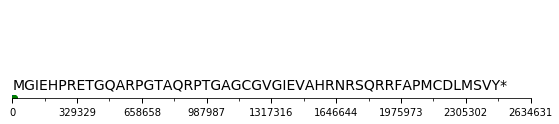

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

peptide = validpeptides[len(validpeptides) - 1]
length = peptide["overallLength"]

# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, length)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)
    
plt.figure(figsize=(8, 6))
n = 8

    
# Multiple Locator
ax = plt.subplot(n, 1, 2)
setup(ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(length / 8))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(length / 16))
ax.text(0.0, 0.1, peptide["sequence"], fontsize=14,
        transform=ax.transAxes)

# Push the top of the top axes outside the figure because we only show the
# bottom spine.
plt.subplots_adjust(left=0.05, right=0.95, bottom=4, top=6)

plt.scatter(peptide["searchRange"][0], 0, c="red")
plt.scatter(peptide["searchRange"][1], 0, c="red")
plt.scatter(peptide["closestB"]["start"], 0, c="blue")
plt.scatter(peptide["closestB"]["end"], 0, c="blue")
plt.scatter(peptide["closestC"]["start"], 0, c="green")
plt.scatter(peptide["closestC"]["end"], 0, c="green")

plt.show()